# Additive Modelling
In this notebook we demonstrate how to fit an additive Gaussian process model in GPJax, first demonstrating the initial "Additive Gaussian Process" of [Devenaud et al. (2011)](https://proceedings.neurips.cc/paper_files/paper/2011/hash/4c5bde74a8f110656874902f07378009-Abstract.html) and then the recent "Orthogonal Additive Gaussian Process" of [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf).


In [1]:
import jax
# Enable Float64 for more stable matrix inversions.
jax.config.update("jax_enable_x64", True)

from dataclasses import dataclass
import warnings
from typing import List, Union

import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
colors = rcParams["axes.prop_cycle"].by_key()["color"]


In [2]:
# prepare some plotting utilities
x1_plot, x2_plot = jnp.meshgrid(jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50))
xplot2d = jnp.stack([x1_plot.reshape(-1), x2_plot.reshape(-1)]).T # [2500, 2]
xplot1d = jnp.stack([jnp.linspace(-1.5,1.5,50), jnp.linspace(-1.5,1.5,50)]).T # [50, 2]
def contour_plot(Z, ax):
    Z = Z.reshape(50, 50)
    cp = ax.contourf(x1_plot, x2_plot, Z)
    ax.scatter(X[:,0], X[:,1], c="red", marker="x", label="data")
    ax.set_xlim(-1.5,1.5)
    ax.set_ylim(-1.5,1.5)

## Make a toy dataset
We first simulate some data, following the 2d toy problem used as motivation by [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf)

In particular, we consider learning a 2d function that can be decomposed additively.

$f(x_1,x_2) = x_1^2 - 2x_2 + \cos(3x_1)\sin(5x_2)$

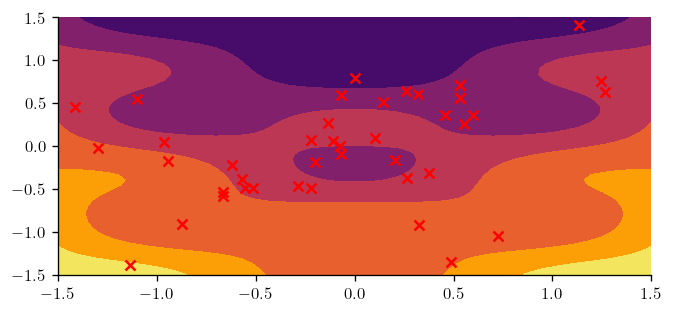

In [3]:
# ground truth function
def f(x): 
    return (x[:,0:1]**2 - 2*x[:,1:2] + jnp.cos(3*x[:,0:1])*jnp.sin(5*x[:,1:2]))

# simulate a noisy dataset of 50 noisy observations
n, noise = 50, 0.01
X = jr.normal(jr.PRNGKey(12345), shape=(n,2)) 
y = f(X) + jr.normal(jr.PRNGKey(12345), shape= (n, 1)) * noise
D = gpx.Dataset(X=X, y=y)

# plot the ground truth function
fig, ax = plt.subplots()
contour_plot(f(xplot2d), ax)

## Build an "Additive Gaussian Process"

We enforce our learned function to have an additive structure by building a new kernel as follows:

First, we choose a *base kernel* $k_i(x_i, x_i')$ for each input dimension $i\in\{1,..,D\}$. We can then combine these kernels to build an order $d\in\{1,..,D\}$ additive kernel as
$$
k_{\textrm{add}_d}(x,x') = \sigma^2_d \sum_{1\leq i_1\leq i_2\leq...\leq i_d\leq D}\left[\prod_{l=1}^dk_{i_l}(x_{i_l},x'_{i_l})\right].
$$

The full kernel is constructed by summing over all orders up to a chosen degree, with $\sigma_d^2$ control the relative importances of high- and low-dimensional functions in the sum. For example, a kernel that considers at most second order interactions is given by
$$
k(x,x') = k_{\textrm{add}_d}(x,x') + k_{\textrm{add}_2}(x,x')
$$

Niave calculation of such kernels can be prohibitvely expensive due to the very large number of terms in their additive composition. Fortunately, we can follow [Devenaud et al. (2011)](https://proceedings.neurips.cc/paper_files/paper/2011/hash/4c5bde74a8f110656874902f07378009-Abstract.html) and use the Newton-Girad identity to efficiently compute the kernel in polynomial (rather than exponential) time.


In [4]:
@dataclass()
class AdditiveKernel(gpx.kernels.AbstractKernel):
    r"""Build an additive kernel from a list of individual base kernels for a specific maximum interaction depth."""
    kernels: list[gpx.kernels.AbstractKernel] = None
    max_interaction_depth: ScalarInt = gpx.base.static_field(1)
    interaction_variances: Float[Array, " p"] = gpx.param_field(jnp.array([1.0, 1.0]), bijector=tfb.Softplus())
    name: str = "AdditiveKernel"

    def __post_init__(self): # jax/jit requires specifying max_interaction depth even though this could be infered from length of interaction_variances
        assert self.max_interaction_depth == len(self.interaction_variances) - 1, "Number of interaction variances must be equal to max_interaction_depth + 1"

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute the additive kernel between a pair of arrays."""
        ks = jnp.stack([k(self.slice_input(x),self.slice_input(y)) for k in self.kernels])
        return jnp.dot(self._compute_additive_terms_girad_newton(ks), self.interaction_variances)
            
    @jax.jit   
    def _compute_additive_terms_girad_newton(self, ks: Num[Array, " D"]) -> ScalarFloat:
        r"""Given a list of inputs, compute a new list containing all products up to order
        `max_interaction_depth`. For efficiency, we us the Girad Newton identity 
        (i.e. O(d^2) instead of exponential).
        """
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks[None, :],powers) # [p+1, d]
        e = jnp.ones(shape=(self.max_interaction_depth+1), dtype=jnp.float64) # lazy init then populate
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = jax.vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*s[k, :])(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing))
        return jnp.array(e) # [max_interaction_depth + 1]
    
    def get_specific_kernel(self, component_list: List[int] = []) -> gpx.kernels.AbstractKernel:
        r""" Get a specific kernel from the additive kernel corresponding to component_list."""
        var = self.interaction_variances[len(component_list)]
        kernel = gpx.kernels.Constant(constant = var)
        for i in component_list:
            kernel = kernel * self.kernels[i]
        return kernel

In [5]:
class AdditivePosterior(gpx.gps.ConjugatePosterior):
    r"""
    Build an additive posterior from an additive kernel and a Gaussian likelihood. We have included an
    additional method to allow predictions for specific additive components, as specified by a
    component_list, e.g. [0, 1] corresponds to the component that takes in the zeroth and first inputs.
    """

    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditivePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        Kxx = self.prior.kernel.gram(train_data.X)
        Kxt = specific_kernel.cross_covariance(train_data.X, test_inputs)
        Sigma = cola.PSD(Kxx + cola.ops.I_like(Kxx) * self.likelihood.obs_stddev**2)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)
        mean =  jnp.matmul(Sigma_inv_Kxt.T, train_data.y)
        covariance = specific_kernel.gram(test_inputs) - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), cola.PSD(covariance))

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        component_posterior = self.predict_additive_component(train_data.X, train_data, component_list)
        full_posterior= self.predict(train_data.X, train_data)
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())



Now lets try on the dataset. we fit additive models of `max_interaction_depth` 0 (i.e. a constant model), 1 and 2.

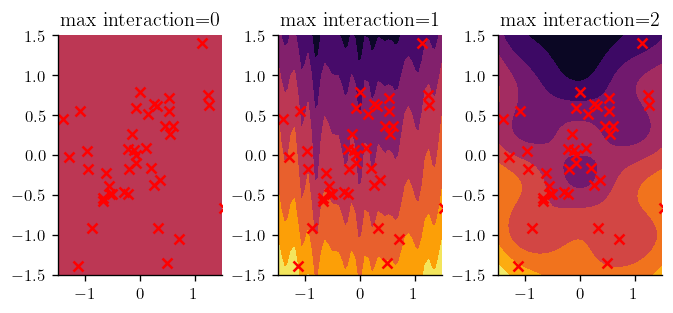

In [6]:
meanf = gpx.mean_functions.Zero()
base_kernels = [gpx.kernels.RBF(active_dims=[0], lengthscale=jnp.array([0.1])), gpx.kernels.RBF(active_dims=[1], lengthscale=jnp.array([0.1]))]
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=noise)
obj = gpx.objectives.ConjugateLOOCV(negative=True)

fig, ax = plt.subplots(nrows=1, ncols=3)
for i in [0,1,2]:
    
    kernel = AdditiveKernel(
        kernels=base_kernels,
        interaction_variances=jnp.array([1.0]*(i+1)) * jnp.var(D.y), 
        max_interaction_depth=i, 
        )

    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = AdditivePosterior(prior =prior, likelihood=likelihood)
    opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)
    contour_plot(opt_posterior.predict(xplot2d, D).mean(), ax[i])
    ax[i].set_title(f"max interaction={i}")


We can also look at the individual additive components learned by the second order model

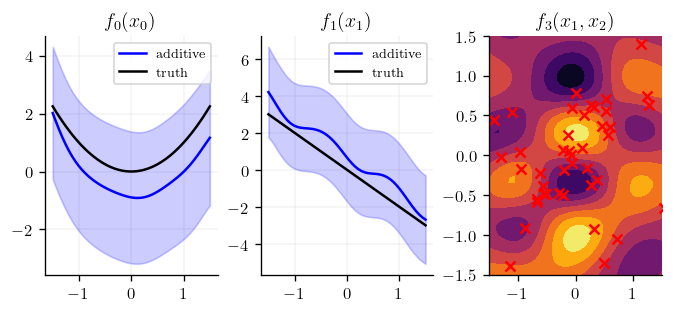

In [7]:
# plotting util
def plot_posterior_with_components(opt_posterior, sobol=False):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    for i in [0,1]: # make 1d plots of 1d interactions
        posterior = opt_posterior.predict_additive_component(xplot1d, D, [i])
        mean, std = posterior.mean(), posterior.stddev()
        ax[i].plot(xplot1d[:,i], mean, color="blue", label="additive")
        ax[i].fill_between(xplot1d[:,i], mean - 2 * std,mean + 2 * std, alpha=0.2, color="blue")
        ax[i].set_title(f"$f_{i}(x_{i})$" if not sobol else f"$f_{i}(x_{i})$ has sobol ${opt_posterior.get_sobol_index(D, [i]):.2f}$")
        truth = xplot1d[:,i]**2 if i==0 else -2*xplot1d[:,i]
        ax[i].plot(xplot1d[:,i], truth, color="black", label="truth")
        ax[i].legend()

    # plot 2d interaction
    ax[2].set_title(f"$f_3(x_1,x_2)$" if not sobol else f"$f_3(x_1,x_2)$ has sobol ${opt_posterior.get_sobol_index(D, [0, 1]):.2f}$")
    contour_plot(opt_posterior.predict_additive_component(xplot2d, D, [0, 1]).mean(), ax[2])

# plot learned additive components
plot_posterior_with_components(opt_posterior)

Although the mean predictions are reasonably close to the true values of the additive components $x_1^2$ and $-2x_2$ there is a large ammount of uncertainty. [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf) argue that the high uncertainty is a consequence of the lack of exisiting of an unique additive decomposition. For example
$$
f(x_1,x_2) = (f(x_1) + \Delta_1(x_1)) + (f(x_2) + \Delta_2(x_2)) + (f_{12}(x_1, x_2) - \Delta_1(x_1) - \Delta_2(x_2))
$$
is a valid additive decomposition for any functions $\Delta_1(x_1)$ and $\Delta_2(x_2)$. 

## Roll on the "Orthogonal Additive Kernel"

To mitigate the problem of identifiability, [Lu et al. (2022)](https://arxiv.org/pdf/2206.09861.pdf) apply an additional constraint to each base kernel so that the integral of each function $\{f_i\}_{i=1}^D$ (with respect to some chosen measure) is zero, thus resulting in a unique decomposition. When $f$ has a non-zero mean, a constant offset is included.

More precisely, we "orthogonalise"  base kernel $i$ by conditioning on the event $\int f_i(x_i)p(x_i)dx_i = 0$. Fortunateky, conditioning a GP on a linear operator also results in a GP and so (for certain base measures $p(x_i)$) our model remains tractible. In our implentation below, we assume a unit Gaussian input measure, so you may achieve better results if you transform your inputs to match.

In [8]:
@dataclass()
class OrthogonalRBF(gpx.kernels.AbstractKernel):
    r"""todo only for unit gaussian input measure and zero mean."""
    name: str = "OrthogonalRBF"
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = gpx.param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )

    def __post_init__(self):
        warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")

    def __call__(self, x: Num[Array, " D"], y: Num[Array, " D"]) -> ScalarFloat:
        r"""Compute an orthogonal RBF kernel between a pair of arrays."""
        x = self.slice_input(x) # [d]
        y = self.slice_input(y) # [d]
        ks = jnp.exp(-0.5 * ((x - y) / self.lengthscale) ** 2) # [d]
        ks -=  self._cov_x_s(x) * self._cov_x_s(y) / self._var_s() # [d]
        return jnp.prod(ks)
    
    def _cov_x_s(self,x):
        l2 = self.lengthscale ** 2
        return jnp.sqrt(l2 / (l2 + 1.0)) * jnp.exp(-0.5 * (x ** 2) / (l2 + 1.0)) # [d]
        
    def _var_s(self):
        return  jnp.sqrt(self.lengthscale ** 2 / (self.lengthscale ** 2 + 2.0)) # [d]


Now, lets use this new kernel to recreate the plots from above.

/tmp/ipykernel_14270/3421494739.py:10: UserWarning: This kernel is only valid for unit gaussian input measures and zero mean functions.
  warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")


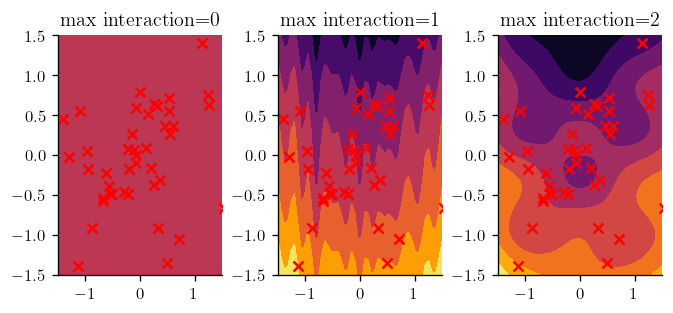

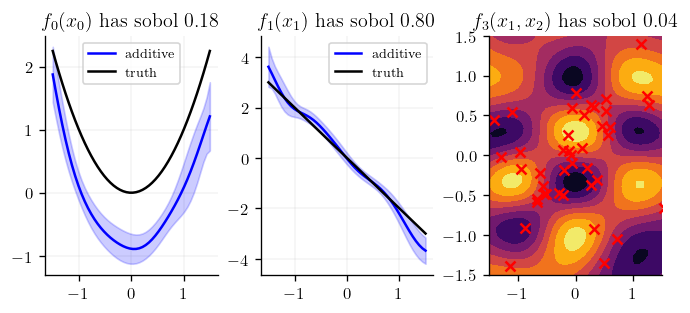

In [9]:
base_kernels = [OrthogonalRBF(active_dims=[0], lengthscale=jnp.array([0.1])), OrthogonalRBF(active_dims=[1], lengthscale=jnp.array([0.1]))]

fig, ax = plt.subplots(nrows=1, ncols=3)
for i in [0,1,2]:
    
    kernel = AdditiveKernel(
        kernels=base_kernels,
        interaction_variances=jnp.array([1.0]*(i+1)) * jnp.var(D.y), 
        max_interaction_depth=i, 
        )

    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
    posterior = AdditivePosterior(prior =prior, likelihood=likelihood)
    opt_posterior, history = gpx.fit_scipy(model=posterior, objective=obj, train_data=D, verbose=False)
    contour_plot(opt_posterior.predict(xplot2d, D).mean(), ax[i])
    ax[i].set_title(f"max interaction={i}")

# plot additive components
plot_posterior_with_components(opt_posterior, sobol=True)

By "orthogonalising" our kernel and so providing an identifiable decomposition, we have greatly reduced the uncertainty of our additve model and have much tighter estimates of the univariate additive components. Note that the constant gap between the truth and our estimated $f_0$ is expected and is accounted for by the not-plotted constant interaction.